In [ ]:
import sys
sys.path.append('../..')
import numpy as np
import matplotlib.pyplot as plt
import math
from exploration.config import mongo_inst

In [ ]:
osu_db = mongo_inst['osu_random_db']

In [ ]:
love = osu_db['beatmap_criteria_curve'].find_one({'_id': 104229})

<ipython-input-6-d8dd57577d08>:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(np.asarray(love['no_mod']['n_pass'])/np.asarray(love['no_mod']['total']))


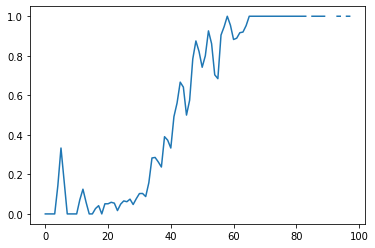

In [ ]:
plt.plot(np.asarray(love['no_mod']['n_pass'])/np.asarray(love['no_mod']['total']))

In [ ]:
bm_popularity_pipeline = [
    {
        '$group': {
            '_id': '$beatmap_id',
            'count': {
                '$sum': 1
            }
        }
    },
    {
        '$sort': {
            'count': -1
        }
    }
]

In [ ]:
top_bm = list(osu_db['osu_scores_high'].aggregate(bm_popularity_pipeline))

In [ ]:
for i, bm in enumerate(top_bm):
    if bm['_id'] == 131891:
        print(i)

58


In [ ]:
bins = [[] for i in range(7)]
cnt = 0
for bm in top_bm:
    bm_info = osu_db['osu_beatmaps'].find_one({'_id': bm['_id']})
    if bm_info['difficultyrating'] < 1:
        continue

    b_i = min(math.floor(bm_info['difficultyrating']) - 1, 6)

    if len(bins[b_i]) < 5:
        bins[b_i].append([bm, bm_info['difficultyrating']])
        cnt += 1
    if cnt == 35:
        break

In [ ]:
for bin in bins:
    bin.sort(key = lambda x: x[1])

In [ ]:
for i, bin in enumerate(bins):
    print(f"\nMost popular {i + 1}* - {i + 2}* beatmaps:")
    for bm, _ in bin:
        compute_bm(bm)


Most popular 1* - 2* beatmaps:
(1036654) 1.62921* cYsmix - Fright March (Gero) [Easy].osu - 4.704492867688916
(397536) 1.68301* Kuba Oms - My Love (W h i t e) [Normal].osu - 15.553854073334854
(315550) 1.71815* Rostik - Liquid (Paul Rosenthal Remix) (Charles445) [Easy].osu - 5.481852458928977
(453359) 1.75883* Rameses B - Flaklypa (-kevincela-) [Normal].osu - 19.80412776421369
(351190) 1.84494* cYsmix feat. Emmy - Tear Rain (jonathanlfj) [Normal].osu - 18.13906372864761

Most popular 2* - 3* beatmaps:
(671413) 2.05844* raja - the light (Damnae) [Normal].osu - 39.73442788201299
(374115) 2.08409* Chasers - Lost (ktgster) [Normal].osu - 21.17133120773235
(557815) 2.09573* Soleily - Renatus (Gamu) [Normal].osu - 31.214629552257353
(397534) 2.67792* Kuba Oms - My Love (W h i t e) [Hard].osu - 92.65260486644534
(351188) 2.92811* cYsmix feat. Emmy - Tear Rain (jonathanlfj) [Hard].osu - 257.7079161815376

Most popular 3* - 4* beatmaps:
(315551) 3.00562* Rostik - Liquid (Paul Rosenthal Remix) 

IndexError: index 517 is out of bounds for axis 0 with size 517

In [ ]:
def compute_acc(score):
    c50, c100, c300, cmiss = score['count50'], score['count100'], score['count300'], score['countmiss']
    return (c50 / 6 + c100 / 3 + c300) / (c50 + c100 + c300 + cmiss)

In [ ]:
compute_bm({'_id': 2596018})

(2596018) 5.66818* Set It Off - Horrible Kids (My Angel Ram) [Kuki's Extra].osu - 2559.656331611526


In [ ]:
def compute_bm(bm):
    bm_id = bm['_id']

    bm_scores = list(osu_db['osu_scores_high'].find({'beatmap_id': bm_id, 'enabled_mods': 0}, {'count50': 1, 'count100': 1, 'count300': 1, 'countmiss': 1, 'mlpp.est_user_pp': 1}))
    bm = osu_db['osu_beatmaps'].find_one({'_id': bm_id})

    acc_scores = np.array([[s['mlpp']['est_user_pp'], compute_acc(s)] for s in bm_scores])
    est_pp, acc = acc_scores.T
    est_pp.sort()

    eval = est_pp[len(acc_scores) - np.sum(acc > .9)]

    diff, name = bm['difficultyrating'], bm['filename']

    print(f'({bm_id}) {diff}* {name} - {eval}')

In [ ]:
MIN_ACC, PP_RANGE, PP_INTERVAL, MAX_PP = .9, 200, 50, 10000
INTERVALS = math.ceil((MAX_PP - PP_RANGE) / PP_INTERVAL)

In [ ]:
acc_scores = np.array([[s['mlpp']['est_user_pp'], compute_acc(s)] for s in bm_scores])
# est_pp, acc = acc_scores[np.argsort(acc_scores[:, 0])].T
est_pp, acc = acc_scores.T
acc = acc > MIN_ACC

NameError: name 'bm_scores' is not defined

In [ ]:
np.sort(est_pp)[len(acc) - np.sum(acc)]

In [ ]:
total, n_pass = np.zeros(INTERVALS), np.zeros(INTERVALS)
j_s, j_e = 0, 0

for i in range(INTERVALS):
    b = i * PP_INTERVAL

    while j_s < len(est_pp) - 1 and est_pp[j_s] < b:
        j_s+=1
    
    while j_e < len(est_pp) - 1 and est_pp[j_e] < b + PP_RANGE:
        j_e+=1
    
    total[i] = j_e - j_s
    n_pass[i] = acc[j_e] - acc[j_s]

In [ ]:
total, n_pass = np.zeros(INTERVALS), np.zeros(INTERVALS)

for i in range(INTERVALS):
    b = i * PP_INTERVAL

    for j in range(len(est_pp)):
        if b < est_pp[j] < b + PP_RANGE:
            total[i] += 1
            n_pass[i] += acc[j]

In [ ]:
x = np.arange(0, INTERVALS) * PP_INTERVAL
plt.plot(x, n_pass / total)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f93d0822-db5a-47ef-9a78-57b8adfbeb20' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>